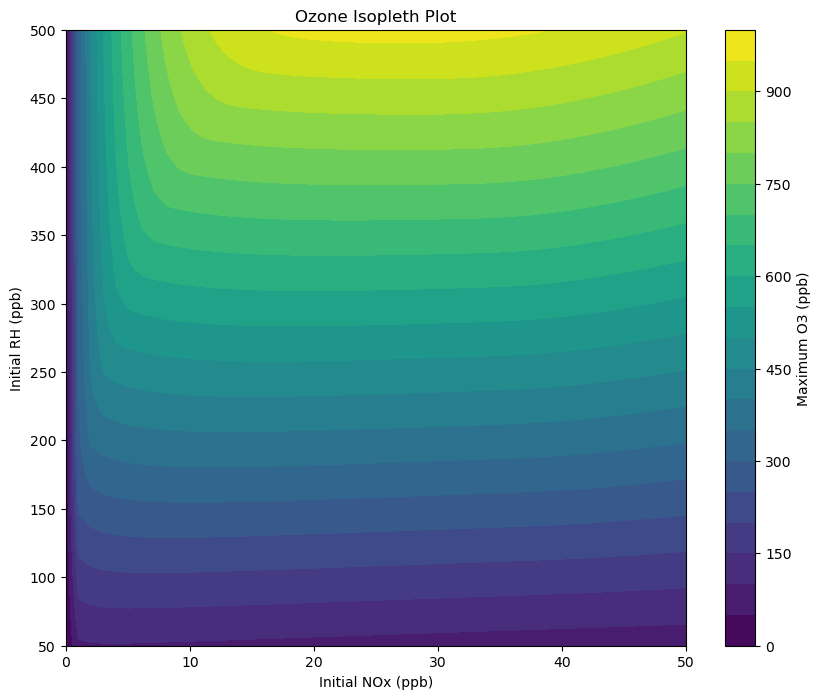

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# Constants and parameters
temp = 298  # Kelvin
pres = 1e5  # Pascals
Rgas = 8.314  # J/(mol-K)
avo = 6.022e23

# Rate constants in cm^3/(molec-s)
k1 = 26.3e-12
k2 = 7.7e-12
k3 = 8.1e-12
k4 = 1.1e-11
k5 = 2.9e-12
k6 = 5.2e-12
k7 = 0.015  # s^-1
k8 = 1.9e-14

# Function to calculate air density
airden = (pres * avo) / (Rgas * temp * 1e6)  # molec/cm^3

# Function defining the system of ODEs
def myfun(t, u, CPHOx):
    f = np.zeros(7)
    f[0] = -k2 * u[3] * u[0] + k7 * u[1] - k8 * u[5] * u[0] - k3 * u[4] * u[0]
    f[1] = k2 * u[3] * u[0] + k3 * u[4] * u[0] + k8 * u[5] * u[0] - k7 * u[1] - k4 * u[2] * u[1]
    f[2] = -k1 * u[6] * u[2] + k3 * u[4] * u[0] - k4 * u[2] * u[1] + CPHOx
    f[3] = k1 * u[6] * u[2] - k2 * u[3] * u[0] - k6 * u[3] * u[4]
    f[4] = k2 * u[3] * u[0] - k3 * u[4] * u[0] - 2 * k5 * u[4]**2 - k6 * u[3] * u[4]
    f[5] = k7 * u[1] - k8 * u[5] * u[0]
    f[6] = -k1 * u[6] * u[2]
    return f

# Function to calculate maximum O3 for given NOx and RH inputs
def calculate_max_O3(nox_ppb, rh_ppb):
    # Convert inputs to concentrations (molec/cm^3)
    Cnox = nox_ppb * 1e-9 * airden
    Crh = rh_ppb * 1e-9 * airden
    CPHOx = 0.1 * 1e-12 * airden  # constant PHOx in molec/(cm^3-s)
    
    # Initial conditions
    u0 = np.zeros(7)
    u0[0] = Cnox * (2 / 3)  # NO
    u0[1] = Cnox * (1 / 3)  # NO2
    u0[2] = 0  # OH
    u0[3] = 0  # RO2
    u0[4] = 0  # HO2
    u0[5] = 0  # O3
    u0[6] = Crh  # RH
    
    # Time parameters
    t0 = 0
    tmax = 96 * 3600  # simulate for 96 hours
    Dt = 2  # time step in seconds
    t_eval = np.arange(t0, tmax, Dt)
    
    # Solve the ODEs
    sol = solve_ivp(myfun, [t0, tmax], u0, args=(CPHOx,), method='LSODA', t_eval=t_eval)
    
    # Calculate maximum O3 concentration (convert to ppb)
    max_O3 = np.max(sol.y[5]) * (1e9 / airden)  # convert to ppb
    return max_O3

# Grid for NOx and RH values
nox_range = np.linspace(0, 50, 50)  # NOx in ppb
rh_range = np.linspace(50, 500, 50)  # RH in ppb
NOX, RH = np.meshgrid(nox_range, rh_range)

# Calculate maximum O3 for each combination of NOx and RH
O3_max = np.zeros_like(NOX)
for i in range(NOX.shape[0]):
    for j in range(NOX.shape[1]):
        O3_max[i, j] = calculate_max_O3(NOX[i, j], RH[i, j])

# Plot the isopleth
plt.figure(figsize=(10, 8))
contour = plt.contourf(NOX, RH, O3_max, levels=20, cmap="viridis")
plt.colorbar(contour, label="Maximum O3 (ppb)")
plt.xlabel("Initial NOx (ppb)")
plt.ylabel("Initial RH (ppb)")
plt.title("Ozone Isopleth Plot")
plt.show()